# 4개 모델 성능 비교
```
4개 모델 성능 비교표
        
    모델	Accuracy	Recall (flood=1)	ROC AUC
RandomForest	0.9811	         0.8000	                0.9843
XGBoost     	0.9641	         0.8765              	0.9775
LSTM+CNN	0.5873	         0.8642              	0.7688
Transformer	0.7299	         0.6790              	0.7812

해석 요약
RandomForest: 전체적으로 가장 안정적. Accuracy, Recall, ROC AUC 모두 우수.

XGBoost: 침수 예측(Recall)에 가장 뛰어남. 성능 균형 좋음.

LSTM+CNN: Accuracy는 낮지만 Recall은 높아, 침수 감지엔 민감한 편.

Transformer: Recall은 나쁘지 않지만 Precision이 낮고 전체 정확도도 낮은 편.
```

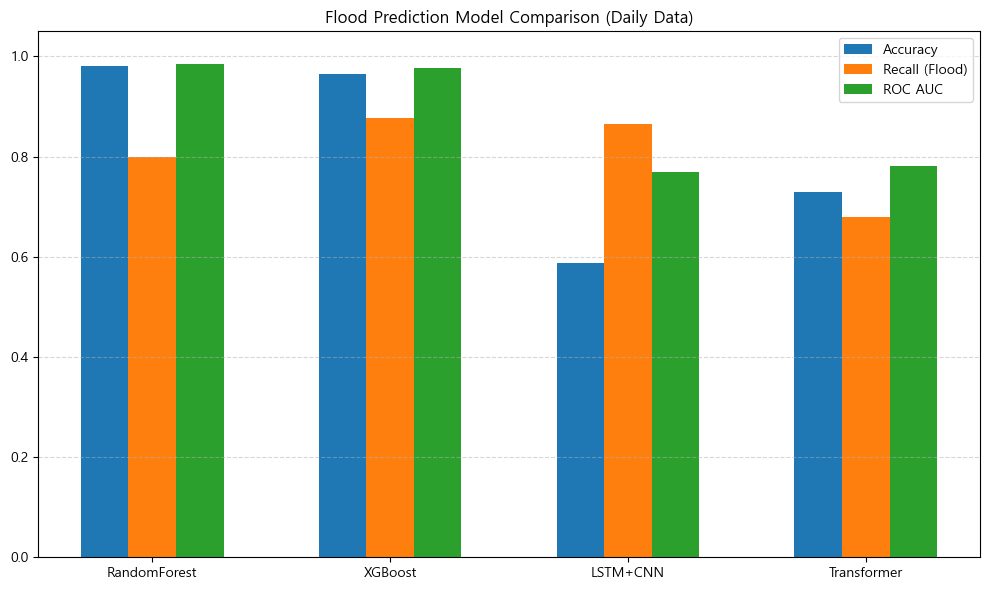

In [12]:
import matplotlib.pyplot as plt

models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer"]
accuracy = [0.9811, 0.9641, 0.5873, 0.7299]
recall = [0.8000, 0.8765, 0.8642, 0.6790]
roc_auc = [0.9843, 0.9775, 0.7688, 0.7812]

plt.figure(figsize=(10, 6))
x = range(len(models))

plt.bar(x, accuracy, width=0.2, label="Accuracy", align="center")
plt.bar([i + 0.2 for i in x], recall, width=0.2, label="Recall (Flood)", align="center")
plt.bar([i + 0.4 for i in x], roc_auc, width=0.2, label="ROC AUC", align="center")

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.05)
plt.title("Flood Prediction Model Comparison (Daily Data)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("daily_model_comparison.png")
plt.show()

# 한글설정, 워닝제거

In [1]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

# api key 활용 및 데이터 수집

In [2]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# Transformer + SMOTE

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# 1. 데이터 로딩
df = pd.read_csv("asos_seoul_daily_with_flood_risk.csv")
features = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs', 'avgRhm', 'avgTs', 'avgTd', 'avgPs']
X = df[features]
y = df['flood_risk']

# 2. 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3. 시퀀스 형태로 변환 (window=7)
def create_sequences(X, y, window=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y.values, window=7)

# 4. 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# 5. SMOTE
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_flat, y_train)
X_train_resampled = X_resampled.reshape(-1, 7, len(features))

# 6. Transformer 모델 구성
def build_transformer(input_shape):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=2, key_dim=32)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.1)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

model = build_transformer((7, len(features)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. 학습
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train_resampled, y_resampled,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/20
129/129 [==============================] - 2s 8ms/step - loss: 0.5901 - accuracy: 0.6519 - val_loss: 0.8264 - val_accuracy: 0.7371
Epoch 2/20
129/129 [==============================] - 1s 6ms/step - loss: 0.5463 - accuracy: 0.7021 - val_loss: 0.7998 - val_accuracy: 0.6913
Epoch 3/20
129/129 [==============================] - 1s 6ms/step - loss: 0.5420 - accuracy: 0.7079 - val_loss: 0.8225 - val_accuracy: 0.6991
Epoch 4/20
129/129 [==============================] - 1s 6ms/step - loss: 0.5395 - accuracy: 0.7145 - val_loss: 0.8220 - val_accuracy: 0.6125
Epoch 5/20
129/129 [==============================] - 1s 6ms/step - loss: 0.5345 - accuracy: 0.7274 - val_loss: 0.7327 - val_accuracy: 0.7303
Epoch 6/20
129/129 [==============================] - 1s 6ms/step - loss: 0.5291 - accuracy: 0.7281 - val_loss: 0.7210 - val_accuracy: 0.7342
Epoch 7/20
129/129 [==============================] - 1s 6ms/step - loss: 0.5233 - accuracy: 0.7325 - val_loss: 0.9442 - val_accuracy: 0.4537
Epoch 

# 저장하기

In [7]:
# 8. 저장
model.save("transformer_daily_model.h5")
with open("transformer_daily_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# 평가하기

In [9]:
# 9. 평가
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_proba = model.predict(X_test).ravel()

23/23 [==============================] - 0s 2ms/step


In [10]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[472 169]
 [ 26  55]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9478    0.7363    0.8288       641
           1     0.2455    0.6790    0.3607        81

    accuracy                         0.7299       722
   macro avg     0.5967    0.7077    0.5947       722
weighted avg     0.8690    0.7299    0.7763       722

ROC AUC Score: 0.781244583116658


# Transformer (일자료 기반) 성능 요약
```
지표	값
Accuracy	72.99%
Precision (1)	24.55%
Recall (1)	67.90%
F1-score (1)	36.07%
ROC AUC	0.7812

**정확도(Accuracy)**는 높지만, 클래스 불균형 때문에 단순히 정확도에만 의존하면 안됨.

flood_risk = 1에 대한 **Recall (재현율)**이 67.9%로 비교적 높고, 이는 실제 침수를 놓치지 않고 예측할 가능성이 있다는 걸 의미.

하지만 **Precision (정밀도)**가 낮아, 침수로 예측한 것 중 실제 침수가 아닌 경우가 많다는 것도 시사.

ROC AUC 0.78은 꽤 괜찮은 편.
```

# 시각화

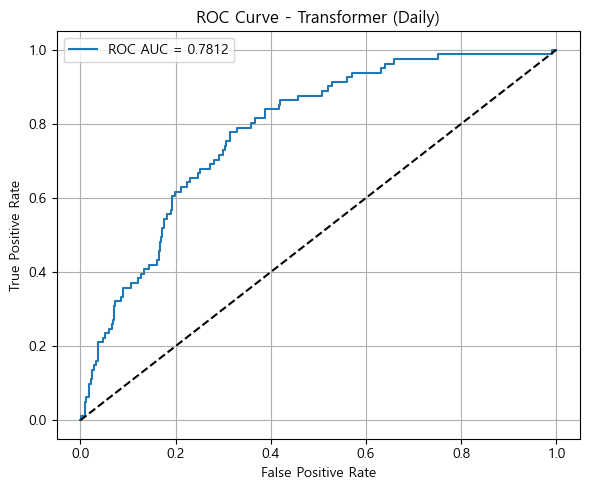

In [11]:
# 10. 시각화
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Transformer (Daily)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("transformer_daily_roc.png")
plt.show()